# KVLCC2 in motions

# Purpose
This notebook analyzes the first results from roll decay simulations in Motions (without vicsous damping).

# Methodology
Quickly describe assumptions and processing steps.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers
import shipflowmotionshelpers.preprocess as preprocess


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
import joblib
from src.helpers import get_ikeda, calculate_ikeda, get_estimator_variation, get_data_variation , get_variation, hatify
from rolldecayestimators import fit_on_amplitudes
from copy import deepcopy
from rolldecayestimators.ikeda import Ikeda, IkedaR, IkedaCarlJohan, IkedaBarge, IkedaBeSimplified
import rolldecayestimators.ikeda_speed
import scipy
import rolldecayestimators.ikeda_speed
import src.helpers

## Load data from Motions:

In [3]:
file_paths = [
    '../data/external/kvlcc2_rolldecay_0kn',
]
#file_path_viscous = 'data/Final_use_in_parametric_roll_simulations/m5030_HADR_B100_Q100_rolldecay_10kn_TS.csv'

#df = helpers.load_time_series(file_path_no_viscous)  # No vicous damping
#df_visc = helpers.load_time_series(file_path_viscous) # Including vicous

In [4]:
df_parameters = pd.DataFrame()
df_parameters =  helpers.load_parameters(file_path=file_paths)
#df_parameters.rename(index={'kvlcc2_rolldecay_0kn':'inviscid'}, inplace=True)
df_parameters

,B,IXY,IXZ,IYY,IYZ,IZZ,KXX,KXY,KYY,KZZ,LPP,S,V,XCG,YCG,ZCG,accx,acto,b1c,b1cr,b1l,b1q,b2c,b2cr,b2l,b2q,b3c,b3cr,b3l,b3q,b4c,b4cr,b4l,b4q,b5c,b5cr,b5l,b5q,b6c,b6cr,b6l,b6q,bdens,body,clev,clevel,curv,dens,densi,dofa,dofactor,dopa,dopadding,dopo,dopower,down,downs,downst,dt,file,file_path_ts,fn,form,free,gravi,heave,heel,hull,inter,k1nd,k2nd,k3nd,k4nd,k5nd,k6nd,kxx,kyy,leve,level,lpp,m,maxti,maxtime,mesh,name,npxp,npyp,nstep,nthr,pitch,powe,power,refle,reflen,rn,roll,rud1,rud2,rud3,rud4,rud5,rud6,rudt,side,slim,stre,strength,surge,sway,ta,tf,tfnhi,tfnhigh,tfnlo,tfnlow,titl,title,trim,upst,upstr,vm_s,wlin,wlme,yaw,ymax,ymin,zcg
kvlcc2_rolldecay_0kn,0.853,0.0,0.0,26.055,0.0,26.055,0.341,7.556,1.177,1.177,4.706,5.981,0.993,2.519,0.0,0.274,0.05,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6,0.3,6.0,6.0,0.00002,1000.0,1000.0,50.0,50.0,2.0,2.0,2.0,2.0,1.0,-5.0,1.0,0.02,..,C:\Dev\Prediction-of-roll-damping-using-fully-...,1.472020e-07,0.23,0.3,9.80665,0.0,0.0,0.002,0.0,0.1,0.1,0.0,0.0,0.0,0.1,0.341185,1.1765,6.0,6.0,4.706,993.42,180.0,180.0,0.0,TRAN,40.0,40.0,30.0,32.0,0.0,2.0,2.0,4.706,4.706,3.95728,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.0,0.5,0.5,0.0,0.0,0.3059,0.3059,4.0,4.0,0.5,0.5,KVLCC2,KVLCC2,0.0,1.0,5.0,0.000001,0.000001,0.000001,0.0,5.0,-5.0,0.2735


In [5]:
time_series = helpers.load_time_series(df_parameters=df_parameters)

<AxesSubplot:xlabel='Time'>

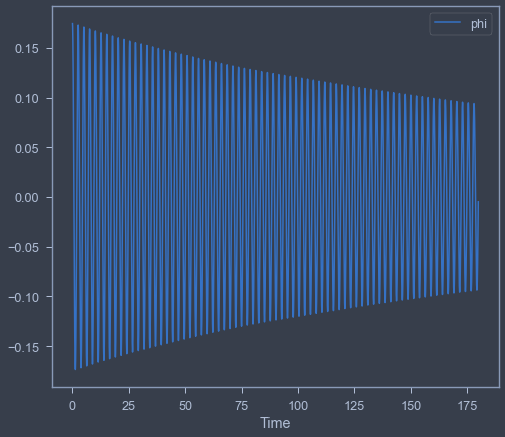

In [6]:
df = time_series['kvlcc2_rolldecay_0kn']
X = df
fig,ax=plt.subplots()
X.plot(y='phi', ax=ax)

## Load MDL results

In [7]:
db = database.get_db()

sql = """
SELECT * from run
INNER JOIN loading_conditions
ON (run.loading_condition_id = loading_conditions.id)
INNER JOIN models
ON (run.model_number = models.model_number)
INNER JOIN ships
ON (run.ship_name = ships.name)
WHERE run.model_number='M5057-01-A' and run.test_type='roll decay' and run.project_number=40178362;
"""
df_rolldecays = pd.read_sql(sql=sql, con=db.engine)
df_rolldecays['rho']=1000
df_rolldecays['g']=9.81
df_rolldecays=df_rolldecays.loc[:,~df_rolldecays.columns.duplicated()]
df_rolldecays.set_index('id', inplace=True)

df_rolldecays['ship_speed'].fillna(0, inplace=True)
df_rolldecays['R'] = 2.4 # Bilge keel radius measured on geometry (full scale)

df_rolldecays=df_rolldecays.loc[[21338,21340,]].copy()

In [8]:
run_paths={
    21338 : {
        'scores_indata_path':'../models/KVLCC2_speed.IN',
        'scores_outdata_path':'../data/interim/KVLCC2_speed.out',
        'roll_decay_model':'../models/KVLCC2_0_speed.pkl',
        'motions_file_paths': ['kvlcc2_rolldecay_0kn'],
        'combined_motions_ikeda': ['kvlcc2_rolldecay_0kn'],  ## combined model with motions and Ikeda
            
            },
    #21340 : {
    #    'scores_indata_path':'../models/KVLCC2_speed.IN',
    #    'scores_outdata_path':'../data/interim/KVLCC2_speed.out',
    #    'roll_decay_model':'../models/KVLCC2_speed.pkl',
    #}
}

In [9]:
runs = OrderedDict()

for run_id, run in run_paths.items():
    
    mdl_meta_data = df_rolldecays.loc[run_id]
    runs[run_id] = new_run = {
        'motions':{},
    }
    
    ## MDL:
    model_mdl = joblib.load(run['roll_decay_model'])
    estimator_mdl = model_mdl['estimator']
    estimator_mdl.calculate_amplitudes_and_damping()
    new_run['model_mdl']=model_mdl
    new_run['estimator_mdl']=estimator_mdl
    
    scale_factor = mdl_meta_data.scale_factor
    new_run['meta_data'] = meta_data={
            'Volume':mdl_meta_data.Volume/(scale_factor**3),
            'GM':mdl_meta_data.gm/scale_factor,
            'rho':mdl_meta_data.rho,
            'g':mdl_meta_data.g,
            'beam':mdl_meta_data.beam/scale_factor,
        }
    
    new_run['results'] = estimator_mdl.result_for_database(meta_data=meta_data)
    results = new_run['results']
    
    # Prediction
    new_run['df_model'] = get_estimator_variation(estimator = estimator_mdl, results=results, meta_data=meta_data)
    
    # Model tests
    new_run['df'] = get_data_variation(estimator = estimator_mdl, results=results, meta_data=meta_data)
    phi_a = new_run['df']['phi_a']
    
    ## Motions
    for motions_file_path in run.get('motions_file_paths',[]):
        motion_file = new_run['motions'][motions_file_path] = {}
        
        motion_file['parameters'] = parameters = df_parameters.loc[motions_file_path]
        
        motion_file['X'] = X = time_series[motions_file_path]
        
                
        motion_file['model'] = model = EstimatorCubic(p0=estimator_mdl.parameters)
        try:
            model.fit(X=X)
        except scipy.linalg.LinAlgError:
            model.fit(X=X)  # Retry
        
        assert model.score() > 0.99
        
        motion_file['meta_data'] = meta_data ={
            'Volume':parameters.V,
            'GM':mdl_meta_data.gm/mdl_meta_data.scale_factor,
            'rho':parameters.dens,
            'g':parameters.gravi,
            'beam':parameters.B,
        }
    
        results = model.result_for_database(meta_data=meta_data)
        motion_file['results'] = results
        model.calculate_amplitudes_and_damping()
        
        # Prediction
        motion_file['df_model'] = get_estimator_variation(estimator = model, results = results, meta_data=meta_data)
                
        # Simulation
        motion_file['df'] = get_data_variation(estimator = model, results = results, meta_data=meta_data)
        
                
    ## Ikeda
    new_run['ikeda'] = ikeda =  {}
    omega0=new_run['results']['omega0']
    #IkedaClass=Ikeda
    IkedaClass=IkedaR
    #IkedaClass=IkedaCarlJohan
    #IkedaClass=IkedaBarge
    #IkedaClass=IkedaBeSimplified
    
    mdl_meta_data['S'] = parameters.S*(scale_factor**2)
    ikeda['estimator'] = ikeda_estimator = get_ikeda(indata_file_path=run['scores_indata_path'], output_file_path=run['scores_outdata_path'], mdl_meta_data=mdl_meta_data, omega0=omega0, phi_a=phi_a, 
                                                     IkedaClass=IkedaClass)
    
    ## Limit area coefficient
    sigma_limit = 0.99  ## 0.99 According to Kawahara
    mask = ikeda_estimator.sections['C_s'] > sigma_limit
    ikeda_estimator.sections.loc[mask,'C_s'] = sigma_limit
    
    ikeda['df'] = results = calculate_ikeda(ikeda = ikeda_estimator)
    results['phi_a'] = phi_a
    results.set_index('phi_a', inplace=True)
    
    ## Convert to dimensional damping [Nm/s]
    ikeda['meta_data'] = meta_data = new_run['meta_data']
    result_ = src.helpers.unhat(df=results, Disp=meta_data['Volume'], beam=meta_data['beam'], g=meta_data['g'], rho=meta_data['rho'])
    ikeda['df'] = results = pd.concat((results,result_), axis=1)
    
    ## Feed the results into a cubic model:
    output = fit_on_amplitudes.fit_cubic(y=results['B_44'], phi_a=results.index, omega0=omega0, 
                                B_1_0=new_run['results']['B_1'], 
                                B_2_0=new_run['results']['B_2'], 
                                B_3_0=new_run['results']['B_3'])
    
    parameters = {
        'B_1A': output['B_1'] / new_run['results']['A_44'],
        'B_2A': output['B_2'] / new_run['results']['A_44'],
        'B_3A': output['B_3'] / new_run['results']['A_44'],
        'C_1A': estimator_mdl.parameters['C_1A'],
        'C_3A': estimator_mdl.parameters['C_3A'],
        'C_5A': estimator_mdl.parameters['C_5A'],
    }
    ikeda['model'] = EstimatorCubic.load(**parameters, X=estimator_mdl.X)
    ikeda['results'] = ikeda['model'].result_for_database(meta_data=meta_data)
    ikeda['df_model'] = get_estimator_variation(estimator = ikeda['model'], results = ikeda['results'], meta_data=new_run['meta_data'])
    
    ## Combined model:
    new_run['combined_models'] = combined_models =  {}
    combined_motions_ikedas = run.get('combined_motions_ikeda',[])
    for combined_motions_ikeda in combined_motions_ikedas:
        combined_models[combined_motions_ikeda] = combined_model = {}
        
        combined_model['motions'] = model_motions = new_run['motions'][combined_motions_ikeda]
        combined_model['ikeda'] = model_ikeda = new_run['ikeda']
        
        df = combined_model['ikeda']['df']
        df_motions = pd.DataFrame()
        df_motions['phi_a'] = df.index.copy()
        df_motions = get_variation(X_amplitudes=df_motions, results = combined_model['motions']['results'], meta_data=combined_model['motions']['meta_data'])
        df_motions.set_index('phi_a', inplace=True)
                
        columns_visc = ['B_L','B_F','B_E','B_BK']
        df_combined = df[columns_visc].copy()
        df_combined['B_W'] = df_motions['B_e']
        df_combined['B'] = df_combined.sum(axis=1)
        combined_model['df'] = df_combined
        
         ## Feed the results into a cubic model:
        output = fit_on_amplitudes.fit_cubic(y=df_combined['B'], phi_a=df_combined.index, omega0=omega0, 
                                B_1_0=new_run['results']['B_1'], 
                                B_2_0=new_run['results']['B_2'], 
                                B_3_0=new_run['results']['B_3'])
    
        parameters = {
            'B_1A': output['B_1'] / new_run['results']['A_44'],
            'B_2A': output['B_2'] / new_run['results']['A_44'],
            'B_3A': output['B_3'] / new_run['results']['A_44'],
            'C_1A': estimator_mdl.parameters['C_1A'],
            'C_3A': estimator_mdl.parameters['C_3A'],
            'C_5A': estimator_mdl.parameters['C_5A'],
        }
        combined_model['model'] = EstimatorCubic.load(**parameters, X=estimator_mdl.X)
        combined_model['results'] = combined_model['model'].result_for_database(meta_data=meta_data)
        combined_model['df_model'] = get_estimator_variation(estimator = combined_model['model'], results = combined_model['results'], meta_data=new_run['meta_data'])
        
        
        


c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\python36-64\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:586:

In [10]:
run = runs[21338]

In [11]:
combined = run['combined_models']['kvlcc2_rolldecay_0kn']
df_combined = combined['df']
df_combined_hat = hatify(df=df_combined, Disp=meta_data['Volume'], beam=meta_data['beam'], g=meta_data['g'], rho=meta_data['rho'])
df_combined_hat.head()

,B_L_hat,B_F_hat,B_E_hat,B_BK_hat,B_W_hat,B_hat
phi_a,,,,,,
0.168032,0.0,0.000369,0.000403,0.0,0.000341,0.001113
0.163232,0.0,0.000367,0.000391,0.0,0.000330,0.001088
0.158999,0.0,0.000366,0.000381,0.0,0.000320,0.001067
0.155245,0.0,0.000364,0.000372,0.0,0.000312,0.001049
0.151536,0.0,0.000363,0.000363,0.0,0.000304,0.001031


<a id='combined_damping'></a>

(0.0, 0.0017)

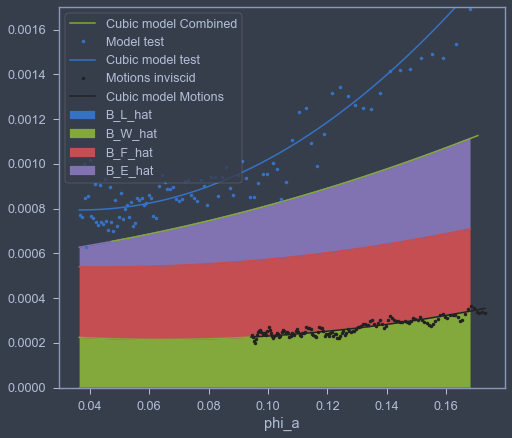

In [12]:
fig,ax=plt.subplots()
interesting_ = ['B_L_hat','B_W_hat','B_F_hat','B_E_hat',]
df_combined_hat.plot.area(y=interesting_, ax=ax)
combined['df_model'].plot(x='phi_a', y='B_e_hat', style='g-', label='Cubic model Combined', ax=ax)

## Model test
run['df'].plot(x='phi_a', y='B_hat', style='b.', label='Model test', ax=ax)
run['df_model'].plot(x='phi_a', y='B_e_hat', style='b-', label='Cubic model test', ax=ax)

## Motions
motion_file = run['motions']['kvlcc2_rolldecay_0kn']
motion_file['df'].plot(x='phi_a', y='B_hat', style='k.', label='Motions inviscid', ax=ax)
motion_file['df_model'].plot(x='phi_a', y='B_e_hat', style='k-', label='Cubic model Motions', ax=ax)
ax.legend()
ax.set_ylim(0,0.0017)

<a id='damping'></a>

(0.0, 0.0017)

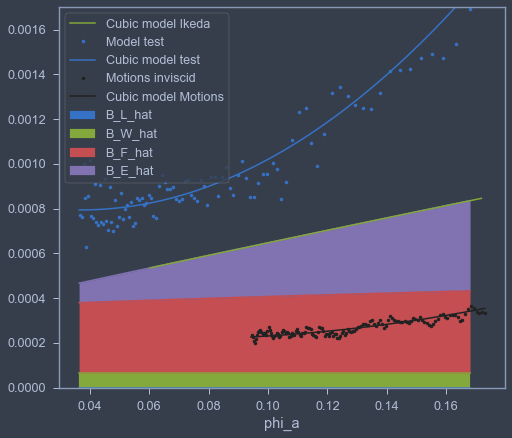

In [13]:
## Ikeda
fig,ax=plt.subplots()
interesting_ = ['B_L_hat','B_W_hat','B_F_hat','B_E_hat',]
df_ikeda = run['ikeda']['df']
df_ikeda.plot.area(y=interesting_, ax=ax)
run['ikeda']['df_model'].plot(x='phi_a', y='B_e_hat', style='g-', label='Cubic model Ikeda', ax=ax)

## Model test
run['df'].plot(x='phi_a', y='B_hat', style='b.', label='Model test', ax=ax)
run['df_model'].plot(x='phi_a', y='B_e_hat', style='b-', label='Cubic model test', ax=ax)

## Motions
motion_file = run['motions']['kvlcc2_rolldecay_0kn']
motion_file['df'].plot(x='phi_a', y='B_hat', style='k.', label='Motions inviscid', ax=ax)
motion_file['df_model'].plot(x='phi_a', y='B_e_hat', style='k-', label='Cubic model Motions', ax=ax)
ax.legend()

ax.set_ylim(0,0.0017)

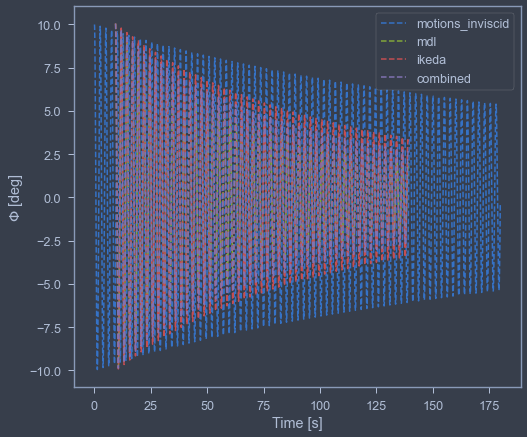

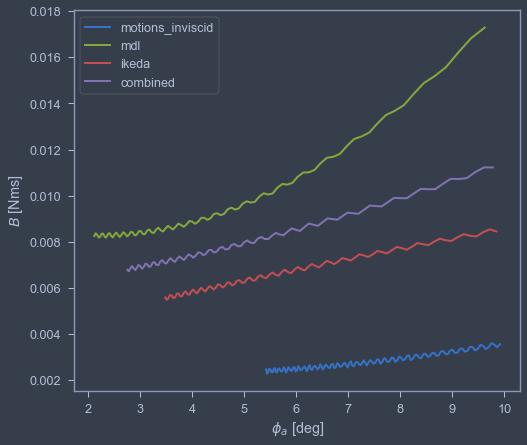

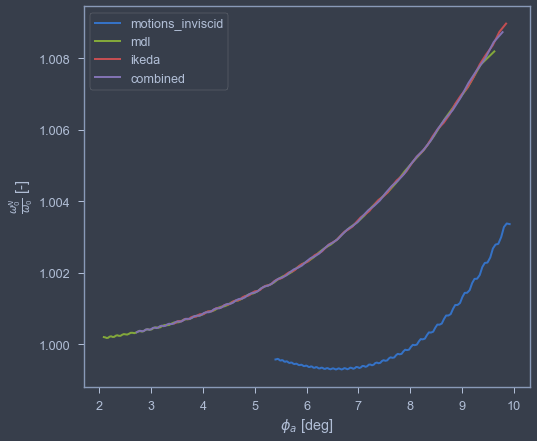

In [14]:
models = OrderedDict()
models['motions_inviscid'] = run['motions']['kvlcc2_rolldecay_0kn']['model']
models['mdl'] = run['estimator_mdl']
models['ikeda'] = run['ikeda']['model']
models['combined'] = run['combined_models']['kvlcc2_rolldecay_0kn']['model']

fig,ax=plt.subplots()
for model_name, model in models.items():
    model.plot_fit(ax=ax, label=model_name, include_model_test=False)
    
fig,ax=plt.subplots()
for model_name, model in models.items():
    model.plot_damping(ax=ax, label=model_name, include_model_test=False)
    
fig,ax=plt.subplots()
for model_name, model in models.items():
    model.plot_omega0(ax=ax, label=model_name, include_model_test=False)

In [15]:
estimator = run['ikeda']['estimator']
ikeda = deepcopy(estimator)
ikeda.bBK=0
ikeda.lBK=0
ikeda.fi_a = np.deg2rad(10)
N=20
R_ratios = np.linspace(0.01,0.15,N)
Rs = estimator.beam*R_ratios
result = pd.DataFrame()
result.index.name='R'

for R,R_ratio in zip(Rs,R_ratios):
    ikeda._R = float(R)
    s=calculate_ikeda(ikeda).iloc[0]
    s.name=R_ratio
    s['R'] = R
    result=result.append(s)

#result['B_E_hat'] = result['B_E_hat'].astype('float')

c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:586: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: divide by zero encountered in double_scalars
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;
c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:190: RuntimeWarning: invalid value encountered in double_scalars
  So = (0.3 * pi * l * fi_a * f / bBK + 1.95) * bBK;


Text(0.5, 0, '$\\frac{R}{beam}$')

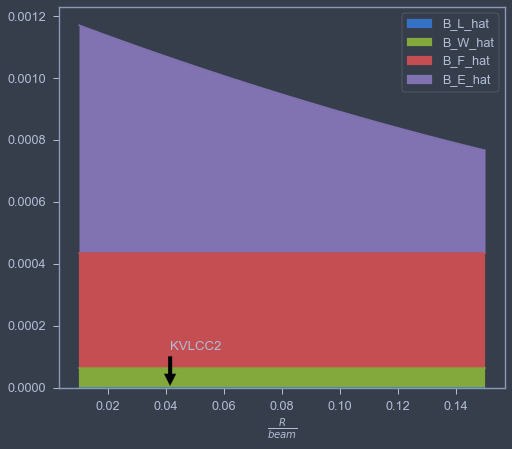

In [16]:
fig,ax=plt.subplots()
interesting_ = ['B_L_hat','B_W_hat','B_F_hat','B_E_hat',]
result.plot.area(y=interesting_, ax=ax)

ylims = ax.get_ylim()
ax.annotate('KVLCC2',xy=(2.4/scale_factor/estimator.beam,0), xytext=(2.4/scale_factor/estimator.beam,0.1*ylims[1]), arrowprops=dict(facecolor='black', shrink=0.05))
ax.set_xlabel(r'$\frac{R}{beam}$')

In [17]:
lpp = estimator.lpp

Rs_data = [
          [lpp*scale_factor,40],    
          [290,15.21],
          [225,2.4],
          [129,2.4],
          [45,8.48],
          [0,40],  
            ]  # Measured on full scale geometry


df_Rs = pd.DataFrame(data=Rs_data, columns=['x','R_b'])
df_Rs['R_b']/=scale_factor
df_Rs['x']/=scale_factor
df_Rs['station'] = df_Rs['x']/lpp*20
df_Rs.sort_values(by='station', inplace=True)

stations = np.arange(0,21,1)
df_Rs_interp = pd.DataFrame(index=stations)

df_Rs_interp['R_b'] = np.interp(stations,df_Rs['station'].values,df_Rs['R_b'].values)


In [18]:
ikeda1 = deepcopy(estimator)
ikeda1.bBK=0
ikeda1.lBK=0
ikeda1.fi_a = np.deg2rad(10)

In [19]:
ikeda2 = deepcopy(ikeda1)
ikeda3 = deepcopy(ikeda1)

ikeda2._R = df_Rs_interp['R_b'].values
ikeda3._R = 2.4/scale_factor

In [20]:
sigma_limit = 0.995
mask = ikeda2.sections['C_s'] > sigma_limit
ikeda2.sections.loc[mask,'C_s'] = 0.995

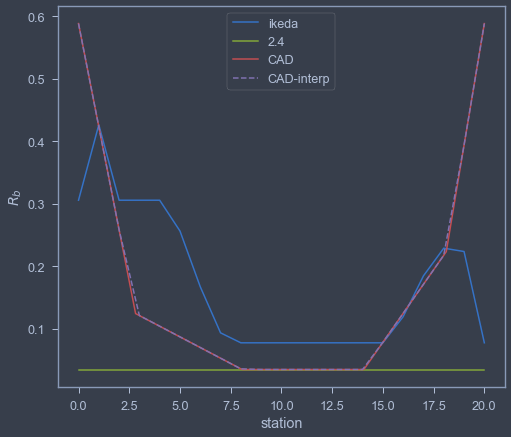

In [21]:
R_b = ikeda1.calculate_R_b()
fig,ax=plt.subplots()
ax.plot(R_b, label='ikeda')
ax.plot([0,20],[ikeda3.R,ikeda3.R], label='2.4')

df_Rs.plot(x='station', y='R_b', ax=ax, label='CAD')
df_Rs_interp.plot(y='R_b', ax=ax, style='--', label='CAD-interp')
ax.set_ylabel(r'$R_b$')
ax.set_xlabel('station')
ax.legend()

c:\dev\rolldecay-estimators\rolldecayestimators\ikeda_speed.py:586: RuntimeWarning: invalid value encountered in sqrt
  gamma=sqrt(pi)*f3*(rmax+2*M/H*sqrt(B0**2*A0**2))/((2*Ts*(1-OG/Ts)*sqrt(H0_prim*sigma_prim)))


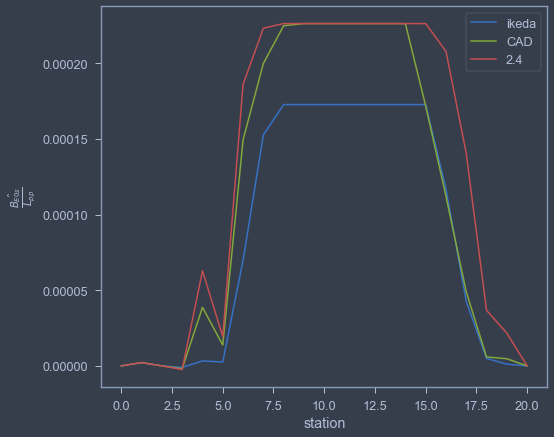

In [22]:
B_E0_s = ikeda1.calculate_B_E0_sections()
B_E0_s_CAD = ikeda2.calculate_B_E0_sections()
B_E0_s_even = ikeda3.calculate_B_E0_sections()

fig,ax=plt.subplots()
ax.plot(B_E0_s, label='ikeda')
ax.plot(B_E0_s_CAD, label='CAD')
ax.plot(B_E0_s_even, label='2.4')

ax.set_xlabel('station')
ax.set_ylabel(r'$\frac{\hat{B_{E0s}}}{L_{pp}}$')
ax.legend()


<AxesSubplot:>

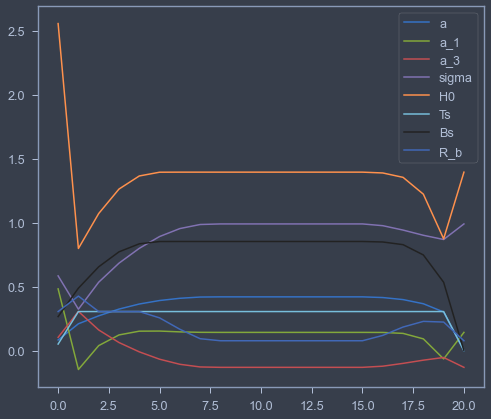

In [23]:
a, a_1, a_3, sigma_s, H = ikeda1.calculate_sectional_lewis_coefficients()

df_lewis = pd.DataFrame(index=stations)
df_lewis['a']=a
df_lewis['a_1']=a_1
df_lewis['a_3']=a_3
df_lewis['sigma']=sigma_s
df_lewis['H0']=H
df_lewis['Ts']=ikeda1.T_s
df_lewis['Bs']=ikeda1.B_s
df_lewis['R_b']=R_b

fig,ax=plt.subplots()
df_lewis.plot(ax=ax)

In [24]:
def plot_variation(key:str, df_lewis):
    
    frame = df_lewis.loc[10]
    
    N = 100
    df_frame = pd.DataFrame(data = np.tile(frame,(N,1)), columns=frame.index)
    
    df_frame[key] = np.linspace(df_lewis[key].min(),df_lewis[key].max(),N)
    
    df_frame['B_E0_s'] = rolldecayestimators.ikeda_speed.eddy_sections(bwl=df_frame.Bs, a_1=df_frame.a_1, a_3=df_frame.a_3, sigma=df_frame.sigma, H0=df_frame.H0, Ts=df_frame.Ts, OG=estimator.OG, 
                                                  R=df_frame.R_b, 
                                                  wE=ikeda1.w, 
                                                  fi_a=ikeda1.fi_a)
    df_frame.set_index(key, inplace=True)
    
    fig,ax=plt.subplots()
    df_frame.plot(y='B_E0_s', ax=ax)

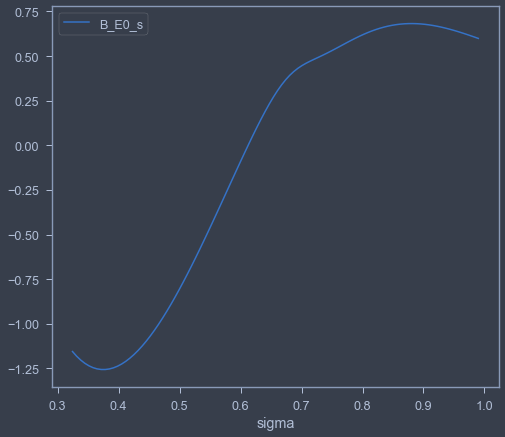

In [25]:
plot_variation(key='sigma', df_lewis=df_lewis)
#plot_variation(key='a_1', df_lewis=df_lewis)

<a id='sigma'></a>

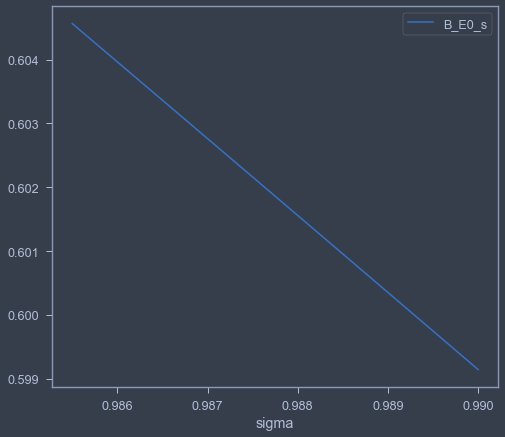

In [26]:
plot_variation(key='sigma', df_lewis=df_lewis.loc[7:11])